# Introduction

Network theory is a powerful tool in the study of complex systems and has been increasingly applied to the field of biology in recent years. One area in particular where network theory has made a significant impact is in the study of protein-protein interaction (PPI) networks in network biology. PPI networks provide a way to represent the molecular interactions between proteins within a cell and are crucial for understanding cellular function and processes such as signal transduction and gene regulation.

Below you will find two networks, representing the yeast (left) and the human (right) interactomes.

![Yeast an human PPIs](images/ppis.png)

While these networks provide extremely valuable information, the number of nodes they include is so large to make understanding their structure difficult. Network theory provides a principled approach that is applicable even to large-scale data sets. By constructing a PPI network, researchers can gain a global perspective on the organization and function of proteins within a cell and make predictions about the effects of perturbations, such as the introduction of a drug or mutation, on the cellular network.

There are several measures in network theory that are useful in the analysis of PPI networks. The degree distribution of a network is a measure of the number of connections (or "degrees") that a node (representing a protein) has to other nodes in the network. A scale-free network is one in which a few nodes have many connections (high-degree nodes), while most nodes have only a few connections (low-degree nodes). PPI networks have been shown to exhibit scale-free behavior, with a small number of highly connected proteins, known as "hubs," playing a central role in the network.

The clustering coefficient is another measure that is useful in the analysis of PPI networks. This measure reflects the degree of local interconnectedness in the network, and it is calculated by counting the number of triangles (sets of three nodes with connections between all pairs) in the network and dividing by the total number of possible triangles that could exist. A high clustering coefficient indicates a high degree of local interconnectedness, while a low clustering coefficient indicates a more dispersed network structure.

Another important measure in network theory is the concept of shortest paths. Shortest paths refer to the shortest distance between two nodes in a network, and they reflect the most direct route of communication or information flow between the two nodes. In PPI networks, the shortest paths between proteins provide insights into the functional relationships between them and can be used to identify key players in signaling pathways or to predict the effects of perturbations on the network. For example, if a mutation occurs in a protein that is part of a shortest path between two other proteins, it is likely to have a significant effect on the communication between those proteins and potentially disrupt normal cellular processes. Therefore, the analysis of shortest paths in PPI networks is important for understanding the organization and function of proteins within a cell and for making predictions about the effects of perturbations on cellular networks.

Finally, PageRank is a measure that was originally developed for the analysis of the World Wide Web, but has been applied to the study of PPI networks as well. PageRank is a measure of the importance of a node in a network and is based on the idea that a node is more important if it is connected to other important nodes. The PageRank of a node is calculated based on the number and importance of the nodes that link to it, as well as the number and importance of the nodes that those nodes link to, and so on.

In this notebook we are going to use some Python code to compute the above measures, and observe how they differ in biological and random networks.

## PPI Network

We are going to use the [SNAP](http://snap.stanford.edu/snappy/index.html) software to store and to manipulate graphs. In the cell below we import the library into our current Python enviroment to gain access to all of its functions.

In [1]:
import snap

We have already downloaded a table describing the [protein-protein interaction network](http://snap.stanford.edu/pathways/) that contains physical interactions between proteins that are experimentally documented in humans.

Let's take a quick look at the first few lines in the file.

In [2]:
!head network.csv

1394,2778
6331,17999
122704,54460
2597,2911
4790,79155
6146,101929876
109,27115
1390,84528
324,10982
26268,6500


Every line represents an edge between two proteins, that are identified by their Entrez Gene ID.

To represent this information in Python we are going to create an appropriate graph object.

In [3]:
g = snap.TUNGraph.New()

"UN" stands for "undirected", and represents the fact that here we are not interested in the direction associated with an edge. We assume protein-protein interactions are symmetric.

In [4]:
seen = set()
with open("network.csv", "rt") as fd:
    for line in fd:
        src, tgt = line.split(",")
        src = int(src)
        tgt = int(tgt)
        
        if src not in seen:
            g.AddNode(src)
            seen.add(src)
            
        if tgt not in seen:
            g.AddNode(tgt)
            seen.add(tgt)
            
        g.AddEdge(src, tgt)

The code above is responsible for reading the edge table and for storing the relevant information in the graph `g`. The main steps are:

  * **Line 1**. Define a set containing all the nodes we have encountered. Initially, the set is empty.
  * **Line 2**. Open the network file. We will read from it through the `fd` variable.
  * **Line 3**. Loop over all the lines in the file.
  * **Line 4**. The IDs of the nodes are separated by a ",", which we use to split the line into two parts.
  * **Lines 5-6**. Initially the node names are strings. Here we convert them to integers.
  * **Line 8**. We can only add a node to a network once. To avoid duplicating them, we check if we have seen that node before. If not, we add it to the graph object and we mark it as seen. Otherwise, the skip it.
  * **Line 16**. We finally add a new edge, identified by the two nodes it connects.
  
To understand the size of the network we have created, we can measure how many nodes and edges it contains.

In [5]:
g.GetNodes()

21557

In [6]:
g.GetEdges()

342353

## Random Graph

It would be useful to compare our newly created PPI network to a second graph of some sort. For this purpose we are going to create on a *completely random* graph.

We can obtain it by means of a simple procedure. First we create as many nodes as there are proteins in the original PPI network. Then we start connecting pairs of nodes at random, until we have the same number of edges as in the first graph.

It would be relatively easy to implement this procedure ourselves, but SNAP already provides a function for doing that.

In [7]:
rg = snap.GenRndGnm(snap.TUNGraph, g.GetNodes(), g.GetEdges())

Notice that we haven't tried to generate any graphical plot of these networks. That's intentional, for two different reasons:

  1. Even on a high-resolution display, it would be difficult to pick apart the nodes, let alone the edges connecting them.
  1. In light of this difficulties, we would rather like to come up with a mathematical measure to compare graphs. We could use it for any network, regardless of size.

## Connectivity

A node is said to have a specific *connectivity degree*, which is a number representing how many neighbors that node is connected to.

![A small graph](images/tree.png)

In the graph above node **1** has a degree of `1`: it has a single neighbor. Node **5**, on the other hand, is connected to both nodes **4** and **6**. Its degree is therefore `2`.

With a single command we can generate a table listing home many nodes in our PPI network have a given degree.

In [8]:
ppi_distrib = [(p.GetVal1(), p.GetVal2()) for p in g.GetDegCnt()]

The entry above is telling us that there are `1607` nodes in the network that have exactly two neighbors.

**Question 1.** What is the number of nodes with no neighbors?

**Question 2.** What is the maximum connectivity degree that you can find?

The list above contains this many entries:

In [9]:
len(ppi_distrib)

460

The degree distribution above captures some aspects of the PPI network using a few hundreds of numbers intead of the original nodes (tens of thousands). That's a huge reduction in complexity, but we don't know yet if this summarized information is useful to classify our networks.

To understand this point better, we need some plots.

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

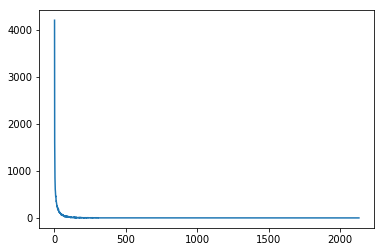

In [11]:
xs = [p[0] for p in ppi_distrib]
ys = [p[1] for p in ppi_distrib]
plt.plot(xs, ys)
plt.show()

In the cells above we did two things. First, we imported *matplotlib*, a Python library for generating plots.

Our degree distribution `ppi_distrib`, then, is represented in Python as a series of pairs of numbers: `(degree, number of nodes)`. If we want to plot these values as points with an $x$ and a $y$ coordinate, we need to isolate all the degrees ($x$ values) into a list; and similarly all the "number of nodes" ($y$ values) into a second list.

Our code is correct, and yet the plot is quite difficult to interpret. The reason is that both types of values ($x$ and $y$ coordinates) span a large range. In situations like this one, using the logarithmic scale comes handy.

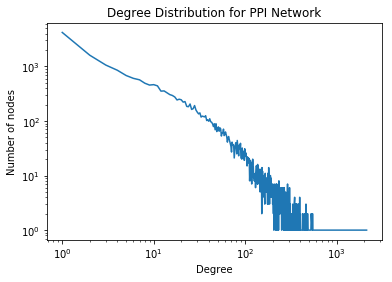

In [12]:
fig, ax = plt.subplots()
ax.loglog(xs, ys)
ax.set_xlabel("Degree")
ax.set_ylabel("Number of nodes")
ax.set_title("Degree Distribution for PPI Network")
plt.show()

The code has become only slightly more complicated than before. We switched to the `loglog` function for changing the scales of the axes. We also took the opportunity to add a few labels to make the plot more readable.

We won't provide an interpretation of this plot straight away. Rather, we will add a second curve to the plot, representing the random graph. Let's see what appears!

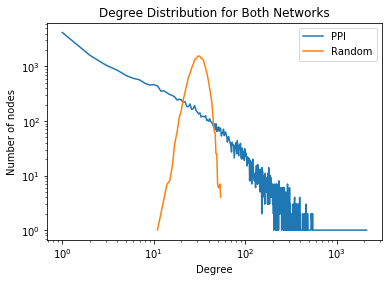

In [13]:
rnd_distrib = [(p.GetVal1(), p.GetVal2()) for p in rg.GetDegCnt()]
rxs = [p[0] for p in rnd_distrib]
rys = [p[1] for p in rnd_distrib]

fig, ax = plt.subplots()
ax.loglog(xs, ys, label = "PPI")
ax.loglog(rxs, rys, label = "Random")
ax.set_xlabel("Degree")
ax.set_ylabel("Number of nodes")
ax.set_title("Degree Distribution for Both Networks")

ax.legend()
plt.show()

A few notes on the code above:

  * **Lines 1-3.** We compute the degree distribution of the random graph, and we split $x$ and $y$ coordinates for every entry.
  * **Line 7.** We plot a second curve for the random network. We attach to it a label, to keep track of its meaning.
  * **Line 12.** We ask Matplotlib to generate a legend.

Now let's go back to the plot. It is evident that the two degree distributions are completely different. While the distribution for the random graph is shaped like a bell, the distribution of the PPI follows a straight line (at least, in the central part of the plot). The latter is called a **scale-free** distribution. As we said, it is associated with a small number of highly connected nodes (proteins), known as "**hubs**," playing a central role in the network.

## Clustering Coefficient

The clustering coefficient is another measure that we can use to characterize the structure of a network, in addition to the degree distribution.

Every node in a graph has an associated clustering coefficient, and in general we should compute all of them. Since this operation is costly, here we are going to take a shortcut. We will sample `1000` nodes at random, and compute the clustering coefficient only for those. Cleary, our results will provide only an approximated representation. For the purpose of our discussion, that will suffice.

In [71]:
def random_node_sample(graph):
    import random
    all_nodes = [n.GetId() for n in graph.Nodes()]
    return random.choices(all_nodes, k = 1000)

In [72]:
ppi_node_sample = random_node_sample(g)
ppi_ccs = [g.GetNodeClustCf(n)  for n in ppi_node_sample]
rnd_ccs = [rg.GetNodeClustCf(n) for n in random_node_sample(rg)]

If we are interested in a network-level summary, we can evaluate the average clustering coefficient over all the sampled nodes.

In [73]:
sum(ppi_ccs) / len(ppi_ccs)

0.1286773394086569

In [74]:
sum(rnd_ccs) / len(rnd_ccs)

0.001408231587270205

As you can notice, the average clustering coefficient for the PPI network is ~ 100 times larger than the corresponding value for the random graph. This reinforces the observation that an organized network is more tightly interconnected than what we would expect in the case of a random structure.

At this point we might expect the hubs of the PPI network to have the largest clustering coefficients. It takes a few lines of code to verify this.

In [75]:
ppi_dgs = [g.GetNI(n).GetDeg() for n in ppi_node_sample]

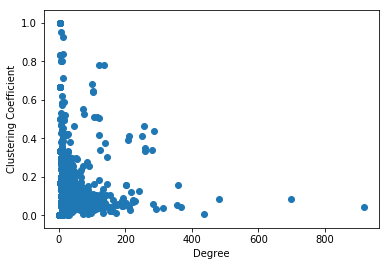

In [76]:
fig, ax = plt.subplots()
ax.scatter(ppi_dgs, ppi_ccs)
ax.set_xlabel("Degree")
ax.set_ylabel("Clustering Coefficient")
plt.show()

Perhaps surprisingly, the plot aboves shows an **inverse** relationship between degree and clustering coefficient. In other terms, hubs (high degrees, large $x$ coordinate) tend to have lower clustering coefficients ($y$ coordinate).

This is not an error in our analysis. These hubs do not tend to form dense clusters with their neighbors, despite having many interactions with them.

This low clustering coefficient of hubs is thought to play a crucial role in the functioning of the network. The hubs serve as connectors between different functional modules in the network, allowing for the rapid transfer of information and material between these modules. If the hubs had a high clustering coefficient, they would have been more tightly connected to a specific functional module, rather than serving as a bridge between modules.